In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import make_axes, generate_Beta_timeseries, get_T_inds, plot_N, plot_FP, name_best_ckpt, generate_Beta_epoch, make_h_combined, same_stim_trial

PATH_TO_RECURRENT_WHISPERER = p+'/code/recurrent-whisperer'#'/home/laura/code/recurrent-whisperer'#
sys.path.insert(0, PATH_TO_RECURRENT_WHISPERER)
from RecurrentWhisperer import RecurrentWhisperer

PATH_TO_FIXED_POINT_FINDER = p+'/code/fixed-point-finder' #'/home/laura/code/fixed-point-finder-experimental'#
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)
from FixedPointFinder import FixedPointFinder

No display found. Using non-interactive Agg backend.


/Users/lauradriscoll/Documents/code/recurrent-whisperer/AdaptiveLearningRate.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance


In [2]:
def comp_eig_decomp(Ms, sort_by='real',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.

  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.

  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = LA.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = LA.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

In [3]:
def plot_FP(X, D, eig_decomps, cr):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = .10
    rf = .10
    
    for s in range(S):
        c = 'k'
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)
            
        plt.plot(X_trial[0],X_trial[1],'o',c = cr, markersize = 2)
        plt.plot(X_trial[0],X_trial[1],'.',c = 'k', markersize = 2)

# def make_axes(model_dir_all,ckpt_n_dir,rule_master,epoch):

#     model = Model(model_dir_all)
#     with tf.Session() as sess:

#         model.saver.restore(sess,ckpt_n_dir)
#         # get all connection weights and biases as tensorflow variables
#         var_list = model.var_list
#         # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
#         # get hparams
#         hparams = model.hp
#         trial_master = generate_trials(rule_master, hparams, mode = 'random', batch_size = 1000, noise_on=False, delay_fac =1)
#         feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
#         h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

#     Beta_epoch = generate_Beta_epoch(h_tf,trial_master)
#     X_pca = Beta_epoch[epoch]    
#     D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
#     return D

In [4]:
def plot_fp_struct_multicolor(m,ckpt_n_dir,tasks,trial_set,r,D,fp_epoch,axes_epoch,do_plot_FP,
                              t_num = 0,qlim = .000001,color_label = 'stim1'):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': 18})

    ## plot w test set of trials
    model = Model(m)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        hparams = model.hp

        for rule_ind in tasks:
            rule = rules_dict['all'][rule_ind]
            trial = generate_trials(rule, hparams, mode='random', batch_size = np.max(trial_set), noise_on=True, delay_fac =1)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

            fldr = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'*')
            f_list = [f for f in glob.glob(fldr)]

            T,S,N = np.shape(h_tf)
            
            stim1_locs = trial.stim_locs[:,0]
            stim2_locs = trial.stim_locs[:,1]
            stim1_strength = trial.stim_strength[:,0]
            stim2_strength = trial.stim_strength[:,1]
            y_loc = trial.y_loc[-1,:]
            
            if color_label == 'stim1' or color_label == 'delay1':
                c_inds = stim1_locs
            elif color_label == 'stim2' or color_label == 'delay2':
                c_inds = stim2_locs
            else:
                c_inds = y_loc
            
            if do_plot_FP==0:
                for s in range(0,S,int(S/100)):
                    c = cmap(c_inds[s]/(2*np.pi))
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
                    
                    if s==0:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
                    else:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)
                    
            elif do_plot_FP==1:
                
                c = 'gray'
                for s in range(0,S,int(S/20)):
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)
                        
                s = t_num
                filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(t_num)+'.npz')

                if os.path.exists(filename):
                    print(filename)
                else:
                    filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(0)+'.npz')
                    
                fp_struct = np.load(filename)
                c = cmap(c_inds[s]/(2*np.pi))

                X_trial = np.dot(h_tf[T_inds,s,:],D)
                plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 2)
                plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 2)
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .5,label = rule)

                fp_logic = fp_struct['qstar']< qlim
                eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_logic,:,:])
                sorted_fps = fp_struct['xstar'][fp_logic,:]
                plot_FP(sorted_fps, D.T, eig_decomps, c)
                
            elif do_plot_FP==2:
                
                for s in range(0,S,int(S/20)):
                    filename = f_list[s]

                    if os.path.exists(filename):
                        print(filename)
                        fp_struct = np.load(filename)
                        c = cmap(c_inds[s]/(2*np.pi))
                        if fp_struct['trial_num']%4==0:

                            X_trial = np.dot(h_tf[T_inds,fp_struct['trial_num'],:],D)
                            plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
                            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
                            if s==0:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
                            else:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)

                            fp_logic = fp_struct['qstar']< qlim
                            eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_logic,:,:])
                            sorted_fps = fp_struct['xstar'][fp_logic,:]
                            plot_FP(sorted_fps, D.T, eig_decomps, c)

            plt.xlabel(r + ' Beta_' + axes_epoch + ' cos@')
            plt.ylabel(r + ' Beta_' + axes_epoch + ' sin@') 
            plt.title(rule + ' ' + fp_epoch+' activity')
            
def plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': 18})

    stim1_locs = trial.stim_locs[:,0]
    stim2_locs = trial.stim_locs[:,1]
    stim1_strength = trial.stim_strength[:,0]
    stim2_strength = trial.stim_strength[:,1]
    y_loc = trial.y_loc[-1,:]

    if color_label == 'stim1' or color_label == 'delay1':
        c_inds = stim1_locs
    elif color_label == 'stim2' or color_label == 'delay2':
        c_inds = stim2_locs
    elif color_label == 'stim1_strength':
        c_inds = stim1_strength
    elif color_label == 'stim2_strength':
        c_inds = stim2_strength
    else:
        c_inds = y_loc

    fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

    for s in up:
        c = cmap(c_inds[s]/(np.max(c_inds)))
        X_trial = np.dot(h_tf[:,s,:],D)
        plt.subplot(2,1,1)
        plt.plot(X_trial[:,0],'-',c = c, linewidth = 2)
        plt.subplot(2,1,2)
        plt.plot(X_trial[:,1],'-',c = c, linewidth = 2)

    plt.subplot(2,1,1)
    for e in trial.epochs.keys():
        plt.text(np.max([trial.epochs[e][0],0])+1,-.3,e,)
        if trial.epochs[e][1]>0:
            plt.plot([trial.epochs[e][1],trial.epochs[e][1]],[-.4,.4],'k',linewidth = .2)
    plt.title(rule + ' color label : ' + color_label)
    plt.xlabel('time in trial')
    plt.ylabel(axes_epoch + ' cosine angle')

    plt.subplot(2,1,2)
    for e in trial.epochs.keys():
        plt.text(np.max([trial.epochs[e][0],0])+1,-.3,e)
        if trial.epochs[e][1]>0:
            plt.plot([trial.epochs[e][1],trial.epochs[e][1]],[-.4,.4],'-k',linewidth = .2)

    plt.title(rule + ' color label : ' + color_label)
    plt.xlabel('time in trial')
    plt.ylabel(axes_epoch + ' sine angle')

In [5]:
def plot_fp_struct_eigenspec(rule,fp_epoch,t_num=0,do_nfp=1):
    
    T,S,N = np.shape(h_tf)
    filename = os.path.join(model_dir_all,'golub_fixed_pts',rule,fp_epoch+'_'+str(t_num)+'.npz')

    if os.path.exists(filename):
        fp_struct = np.load(filename)
        fp_logic = fp_struct['qstar']<.0000001
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_logic,:,:])
        
        plt.subplot()
        
        if do_nfp == 0:
            plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,'.k')
            plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)))
        else:
            for nfp in range(len(eig_decomps)):
                plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,alpha = .1)
                plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)),alpha = .1)

In [6]:
net = 'stepnet'
tasks = [13]
rule = rules_dict['all'][tasks[0]]
fp_epoch = 'stim1'
model_n = 0
if net is 'stepnet':
    dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
elif net is 'highd_inputs':
    dir_specific_all = 'crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

In [7]:
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', batch_size = 1000, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

T,S,N = np.shape(h_tf)
trial_set = range(0,S)
epoch_set = trial.epochs.keys()
print(trial.epochs.keys())

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
['stim1', 'stim2', 'delay1', 'delay2', 'fix1', 'go1']


In [8]:
epoch_order = [4,0,2,1,3,5]

In [9]:
rule

'contextdelaydm1'

In [10]:
trial.stim_strength

array([[1.1459693 , 0.46594983, 1.61203911, 0.68420448],
       [0.9503615 , 0.76756711, 0.96069684, 1.05726728],
       [1.25397617, 0.44306546, 0.71219792, 1.51071469],
       ...,
       [1.0506235 , 0.55641697, 1.18440523, 0.41584542],
       [0.95783995, 1.14063434, 0.86200155, 0.9277694 ],
       [0.39297564, 1.54115446, 0.7431676 , 1.30482149]])

In [15]:
np.shape(D_use)

(512,)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
1
1
1
1
1
1
1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
1
1
1
1
1
1
1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0

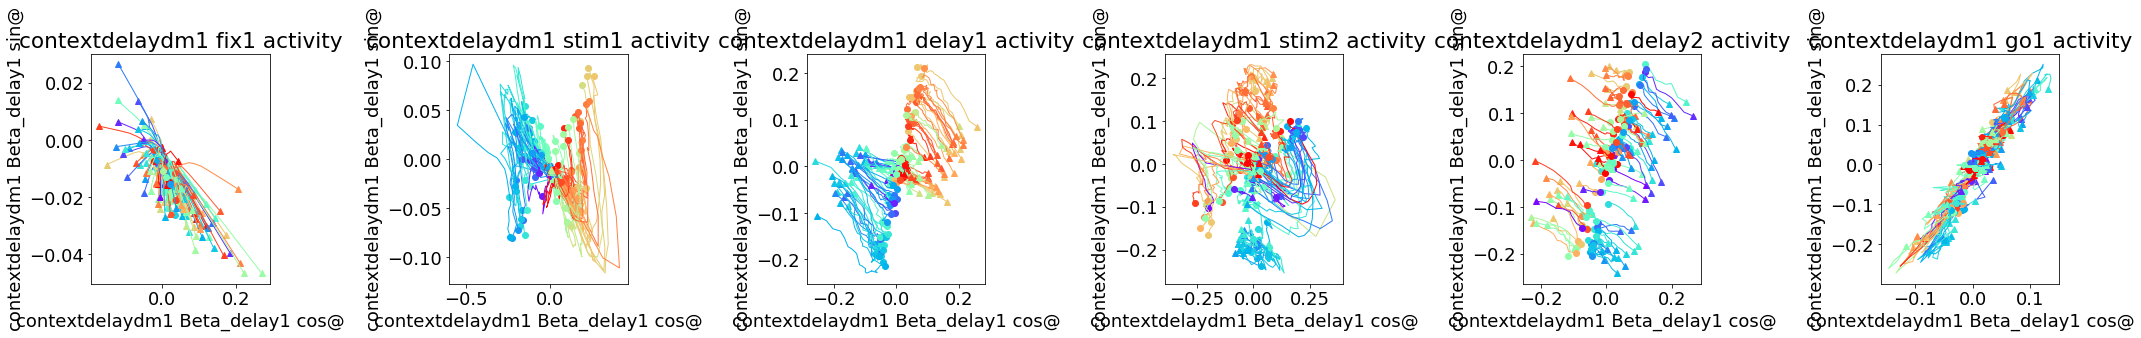

In [17]:
axes_epoch = 'delay1'

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D_stim = make_axes(model_dir_all,ckpt_n_dir,rule,'stim1', mod = 1)
    D_delay = make_axes(model_dir_all,ckpt_n_dir,rule,'delay1', mod = 1)
    D_use = np.concatenate((D_stim[:,0:1],D_delay[:,0:1]),axis = 1)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_use,fp_epoch,axes_epoch,
                              do_plot_FP=0,color_label = 'stim1')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dt

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crys

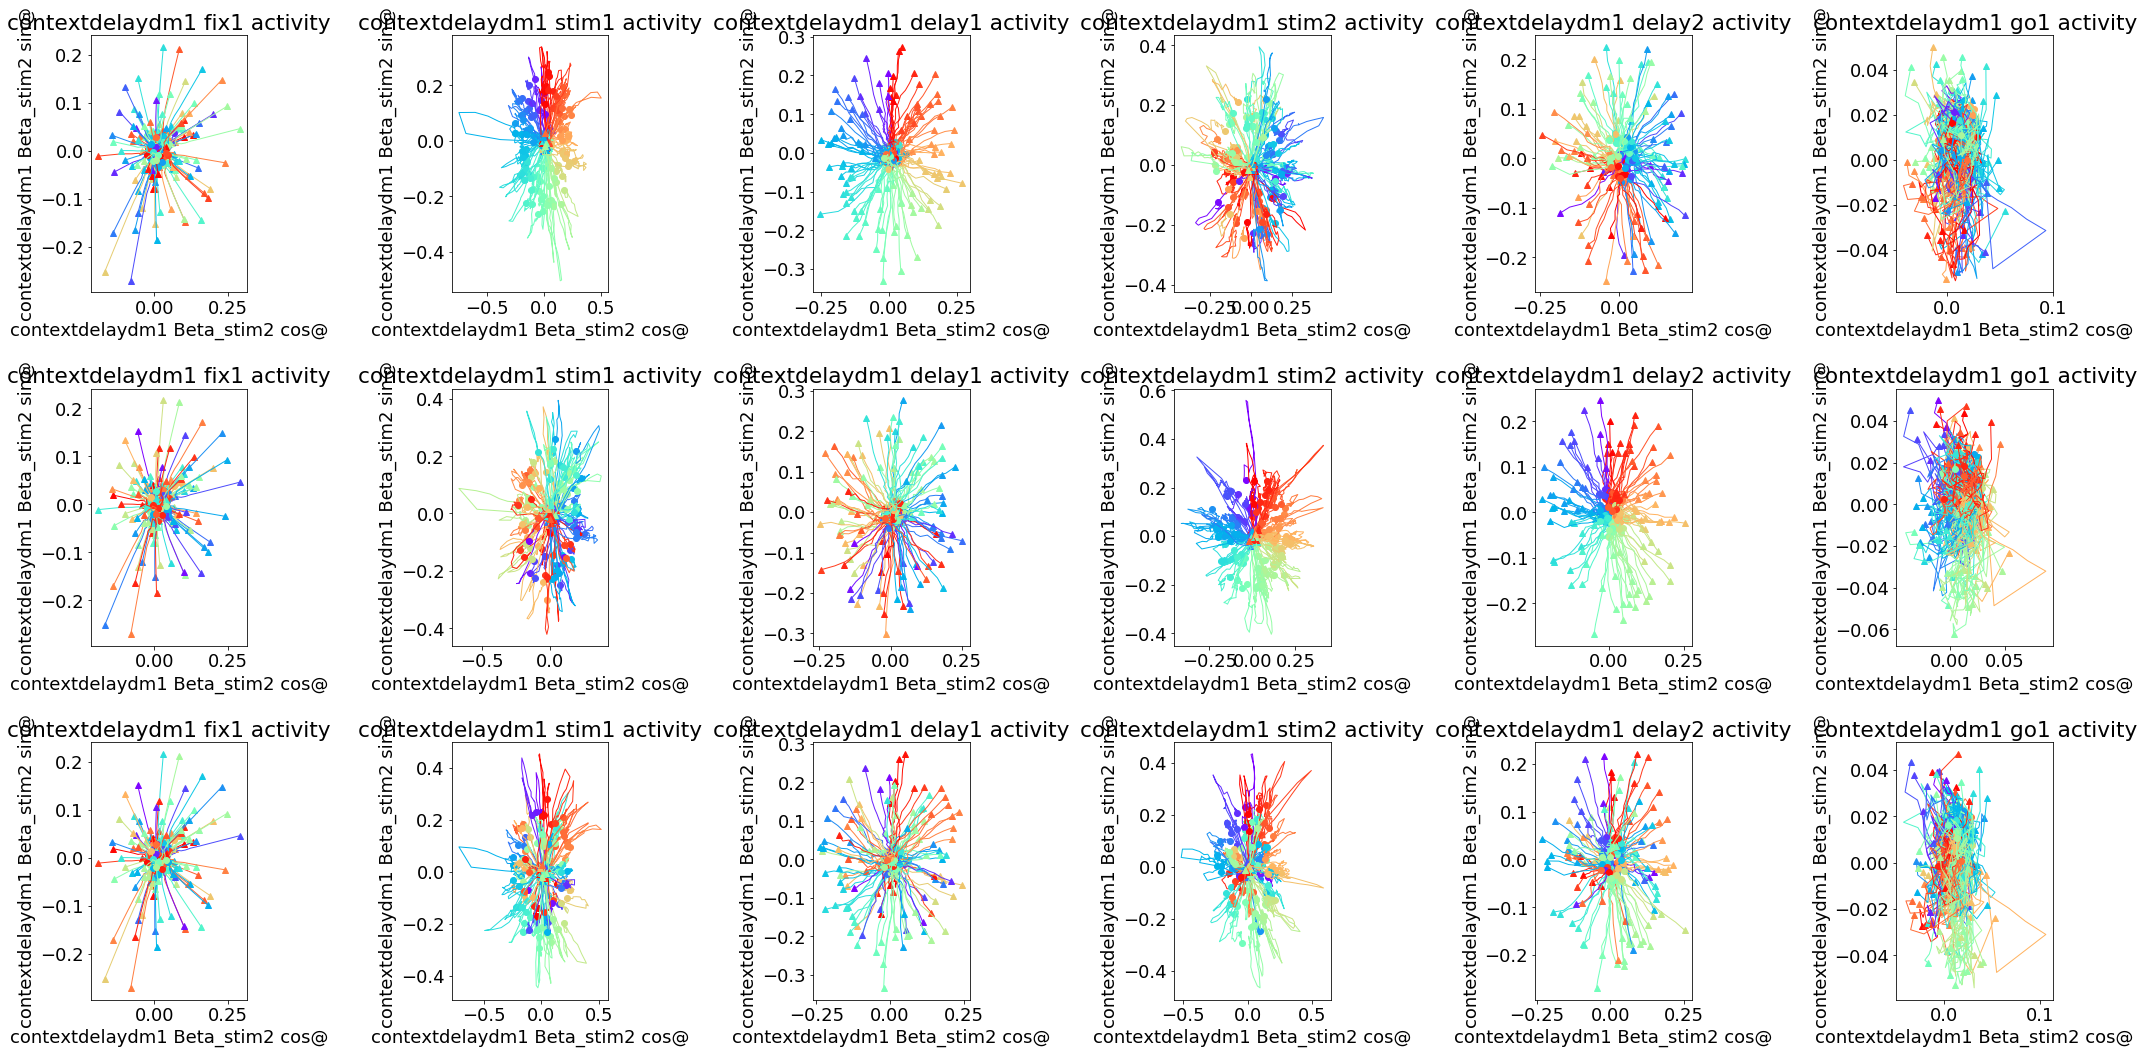

In [23]:
axes_epoch = 'stim2'

fig = plt.figure(figsize=(len(epoch_set)*5,15),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D_stim2 = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(3,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_stim2,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'stim1')
    plt.subplot(3,len(epoch_set),fp_epoch_ind+1+len(epoch_set))
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_stim2,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'stim2')
    plt.subplot(3,len(epoch_set),fp_epoch_ind+1+2*len(epoch_set))
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_stim2,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [78]:
tasks = [13]
rule = rules_dict['all'][tasks[0]]

In [79]:
rule

'contextdelaydm1'

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
2


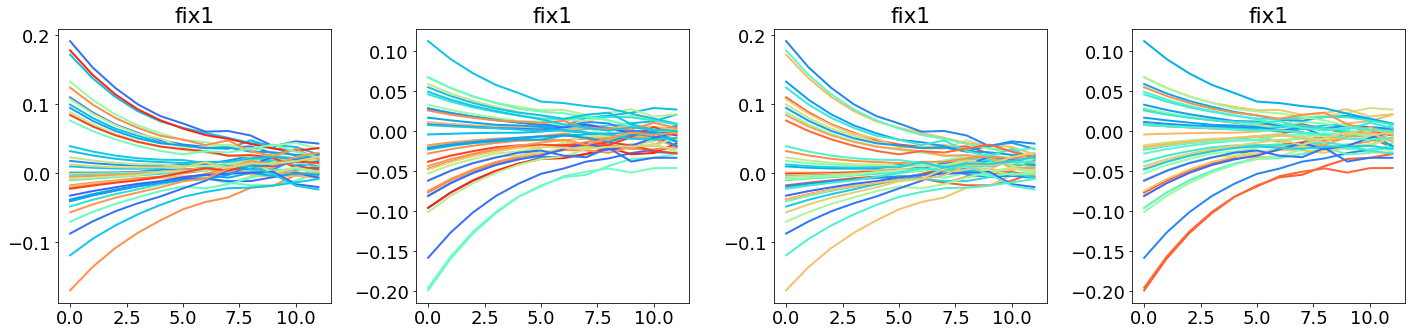

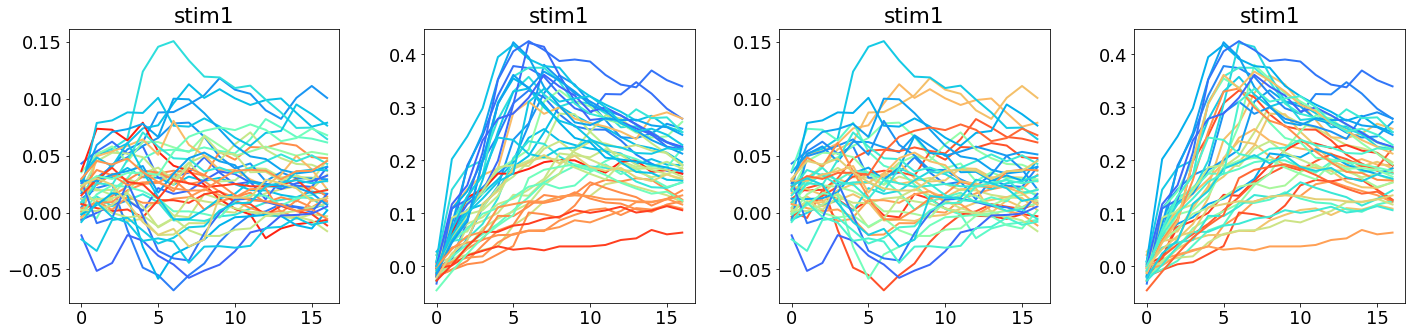

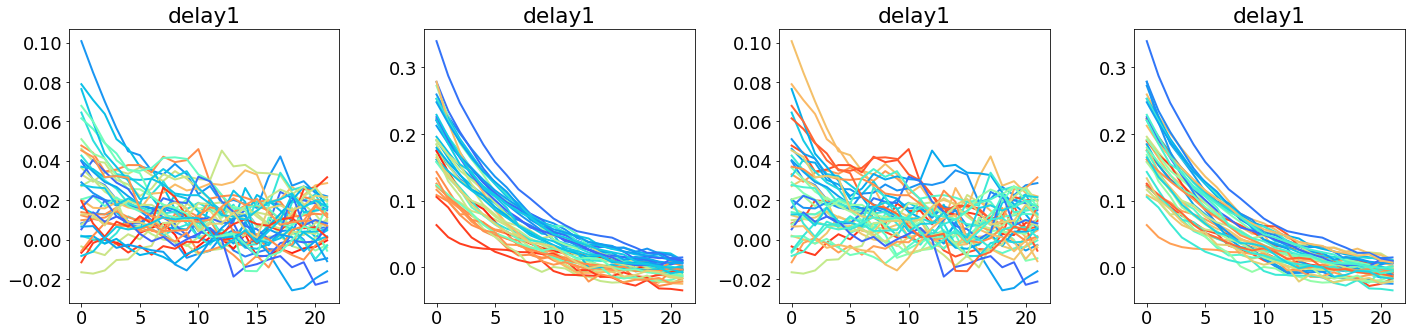

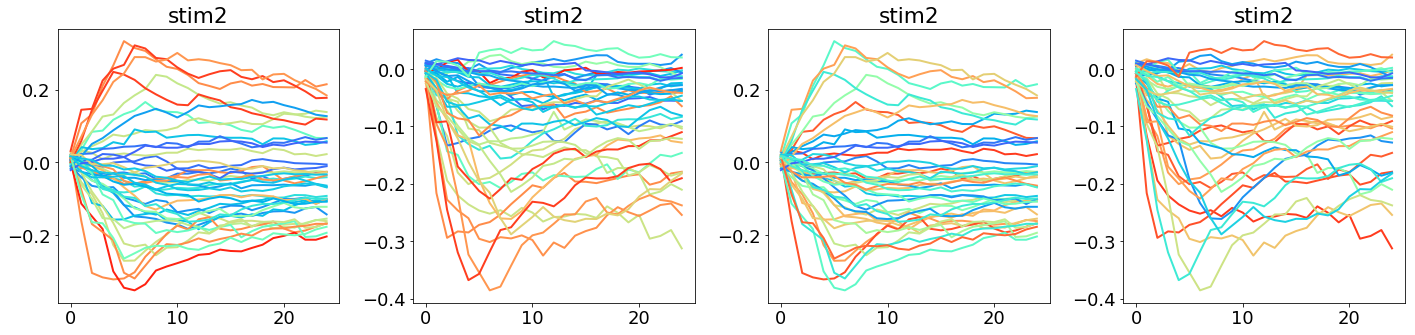

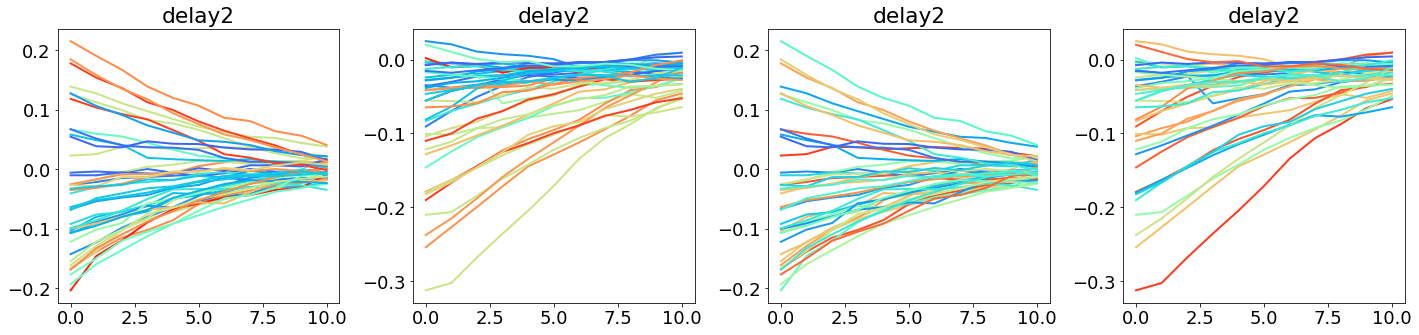

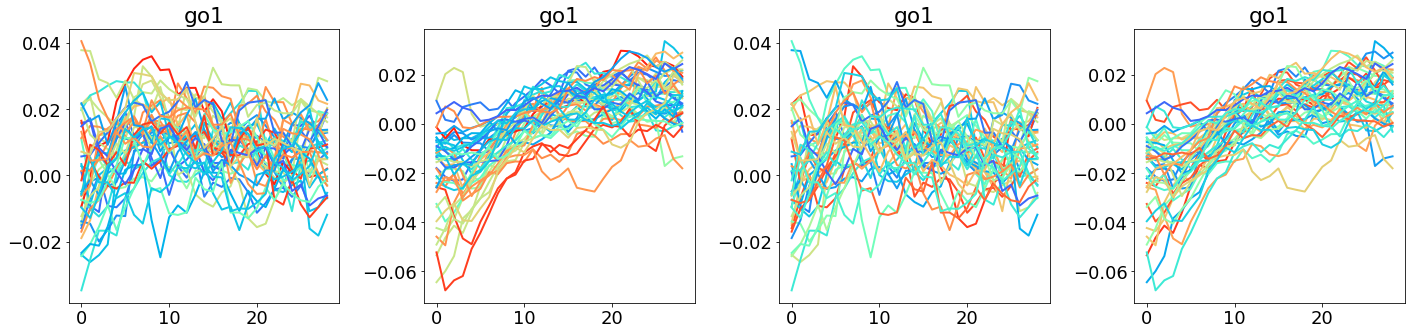

In [74]:
cmap=plt.get_cmap('rainbow')
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    hparams = model.hp

    for rule_ind in tasks:
        rule = rules_dict['all'][rule_ind]
        trial = generate_trials(rule, hparams, mode='random', batch_size = np.max(trial_set), noise_on=True, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

stim1_locs = trial.stim_locs[:,2]
stim2_locs = trial.stim_locs[:,3]
stim1_strength = trial.stim_strength[:,2]
stim2_strength = trial.stim_strength[:,3]
y_loc = trial.y_loc[-1,:]

axes_epoch = 'stim2'
color_label = 'stim2_strength'
trial_subset = stim1_locs
rule = rules_dict['all'][rule_ind]

if color_label == 'stim1_strength':
    c_inds1 = trial.stim_strength[:,0]
    c_inds2 = trial.stim_strength[:,2]
elif color_label == 'stim2_strength':
    c_inds1 = trial.stim_strength[:,1]
    c_inds2 = trial.stim_strength[:,3]
    
up = [i for i, x in enumerate(trial_subset) if x>6]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch,mod = 2)

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    T_inds = get_T_inds(trial,fp_epoch)
    
    fig = plt.figure(figsize=(20,5),tight_layout=True,facecolor='white')
    for s in up:
        
        c = cmap(c_inds1[s]/(np.max(c_inds1)))
        X_trial = np.dot(h_tf[T_inds,s,:],D)
        plt.subplot(1,4,1)
        plt.plot(X_trial[:,0],'-',c = c, linewidth = 2)
        plt.title(fp_epoch)
        plt.subplot(1,4,2)
        plt.plot(X_trial[:,1],'-',c = c, linewidth = 2)
        plt.title(fp_epoch)
        
        c = cmap(c_inds2[s]/(np.max(c_inds2)))
        X_trial = np.dot(h_tf[T_inds,s,:],D)
        plt.subplot(1,4,3)
        plt.plot(X_trial[:,0],'-',c = c, linewidth = 2)
        plt.title(fp_epoch)
        plt.subplot(1,4,4)
        plt.plot(X_trial[:,1],'-',c = c, linewidth = 2)
        plt.title(fp_epoch)
    plt.show()

In [48]:
rule

'contextdelaydm2'

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either


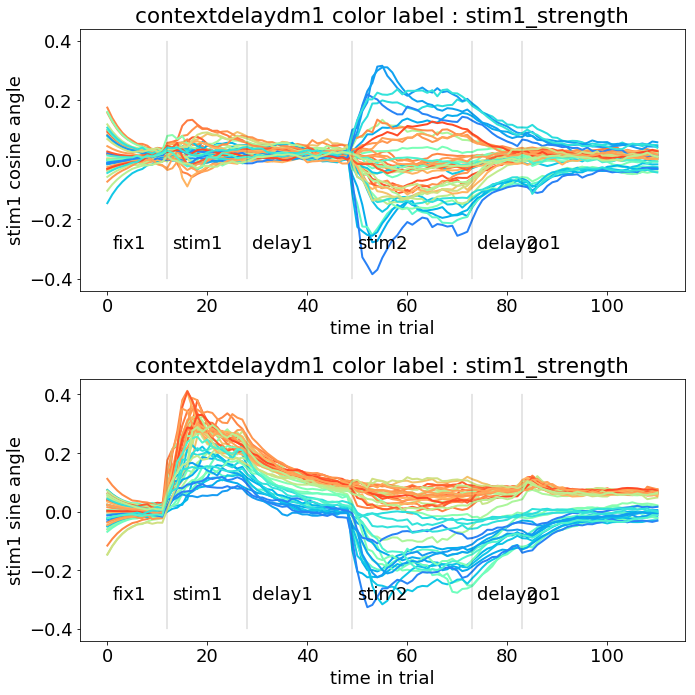

In [65]:
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    hparams = model.hp

    for rule_ind in tasks:
        rule = rules_dict['all'][rule_ind]
        trial = generate_trials(rule, hparams, mode='random', batch_size = np.max(trial_set), noise_on=True, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

stim1_locs = trial.stim_locs[:,0]
stim2_locs = trial.stim_locs[:,1]
stim1_strength = trial.stim_strength[:,2]
stim2_strength = trial.stim_strength[:,3]
y_loc = trial.y_loc[-1,:]

axes_epoch = 'stim1'
color_label = 'stim1_strength'
trial_subset = stim1_locs

trial_subset = [i for i, x in enumerate(stim1_locs) if x>6.14]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)

plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either


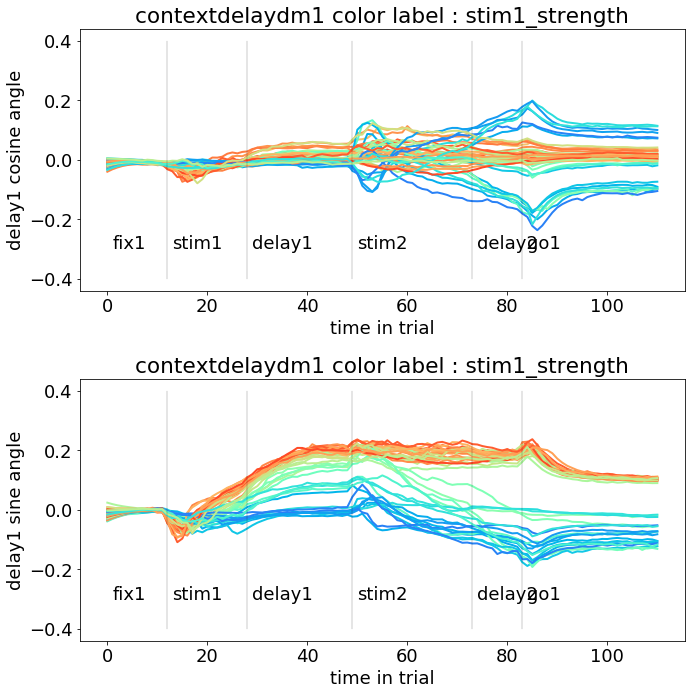

In [66]:
axes_epoch = 'delay1'
color_label = 'stim1_strength'
trial_subset = stim1_locs

trial_subset = [i for i, x in enumerate(stim1_locs) if x>6]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)

plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either


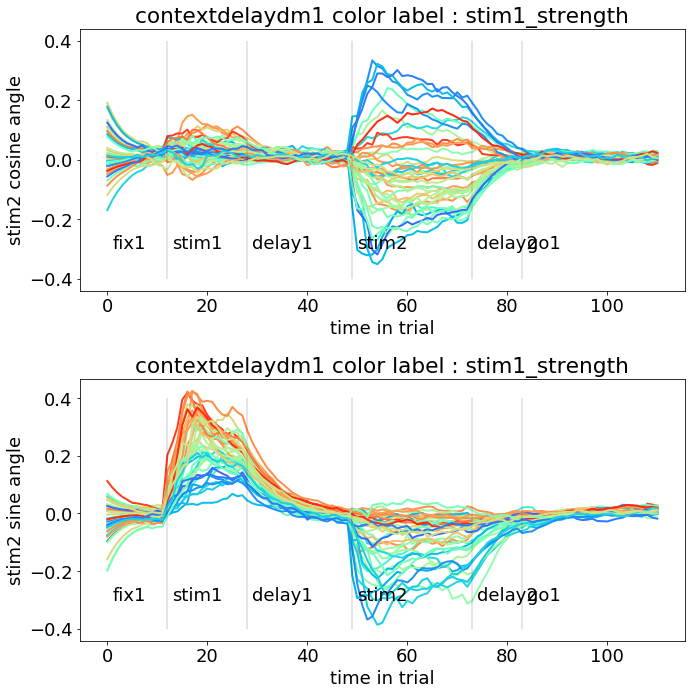

In [75]:
axes_epoch = 'stim2'
color_label = 'stim1_strength'
trial_subset = stim1_locs

trial_subset = [i for i, x in enumerate(stim1_locs) if x>6]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)

plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either


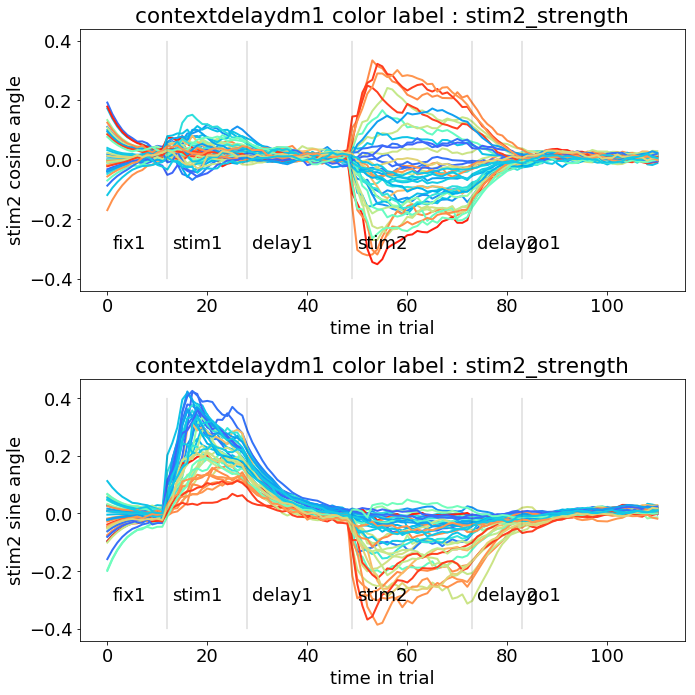

In [76]:
axes_epoch = 'stim2'
color_label = 'stim2_strength'
trial_subset = stim1_locs

trial_subset = [i for i, x in enumerate(stim1_locs) if x>6]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)

plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either


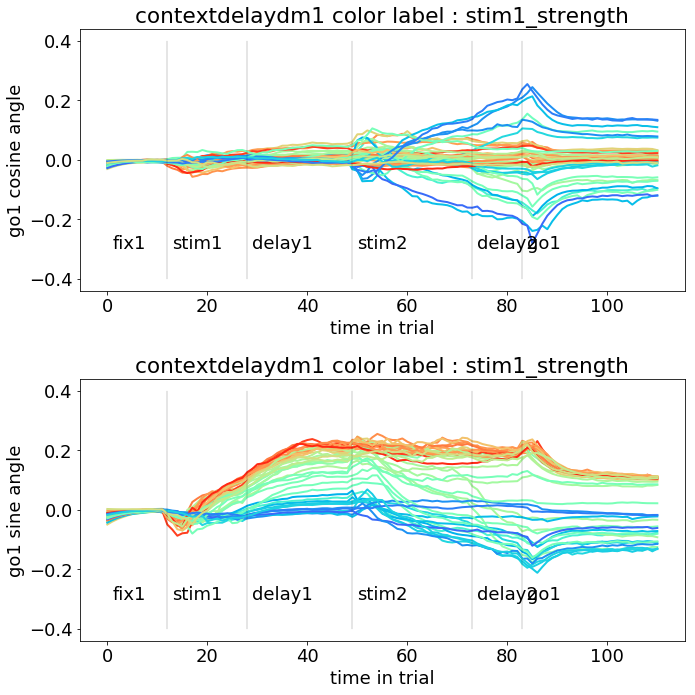

In [80]:
axes_epoch = 'go1'
color_label = 'stim1_strength'
trial_subset = [i for i, x in enumerate(stim1_locs) if x>6]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
either


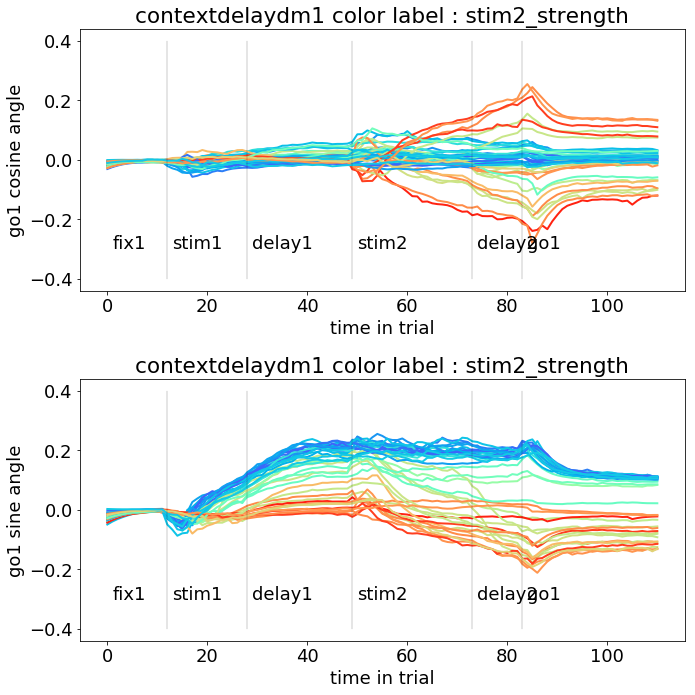

In [81]:
axes_epoch = 'go1'
color_label = 'stim2_strength'
trial_subset = [i for i, x in enumerate(stim1_locs) if x>6]
D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000


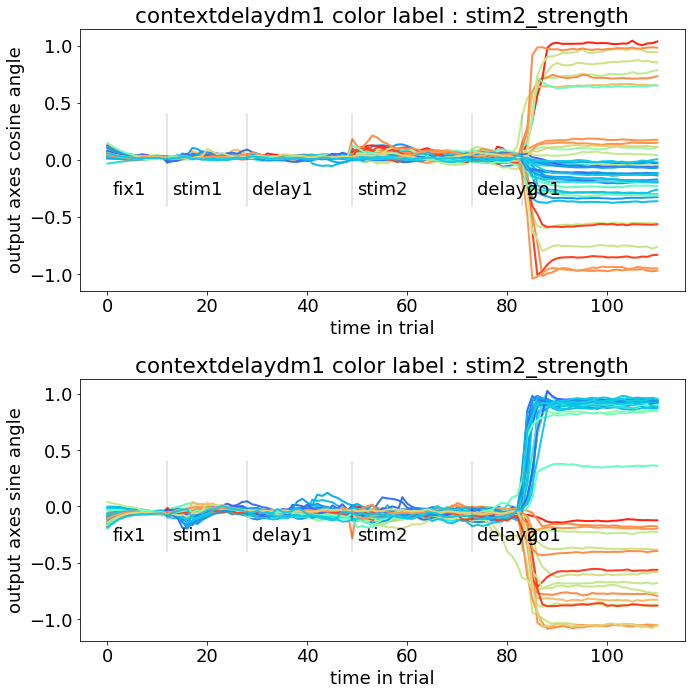

In [82]:
from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(model_dir_all,ckpt_n_dir)

axes_epoch = 'output axes'
color_label = 'stim2_strength'
trial_subset = [i for i, x in enumerate(stim1_locs) if x>6]
D = w_out[:,1:]

plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D)
plt.show()

In [84]:
def generate_Beta_timeseries(h_tf,trial,T_inds,align_group):
    T,S,N = np.shape(h_tf)
    Beta_timeseries = np.empty((N,2,len(T_inds)))

    for t_ind in range(len(T_inds)):
        t = T_inds[t_ind]

        inds_use = np.min(trial.stim_strength,axis=1)>.5
        X = h_tf[t,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan

        stim1_locs = trial.stim_locs[:,0]
        stim2_locs = trial.stim_locs[:,1]
        y_loc = trial.y_loc[-1,:]
            
        if t<trial.epochs['stim2'][0]:
            angle_var = stim1_locs[inds_use]
        elif t<trial.epochs['go1'][0]:
            angle_var = stim2_locs[inds_use]
        else:
            angle_var = y_loc[inds_use]

        y1 = np.expand_dims(np.sin(angle_var),axis = 1)
        y2 = np.expand_dims(np.cos(angle_var),axis = 1)
        y = np.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_timeseries[:,:,t_ind],_ = LA.qr(Beta)

    return Beta_timeseries

In [85]:
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', batch_size = 1000, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

T,S,N = np.shape(h_tf)
trial_set = range(0,S)
epoch_set = trial.epochs.keys()
print(trial.epochs.keys())

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1380000
['stim1', 'stim2', 'delay1', 'delay2', 'fix1', 'go1']


In [86]:
epoch_set

['stim1', 'stim2', 'delay1', 'delay2', 'fix1', 'go1']

Text(0.5,1,'go1')

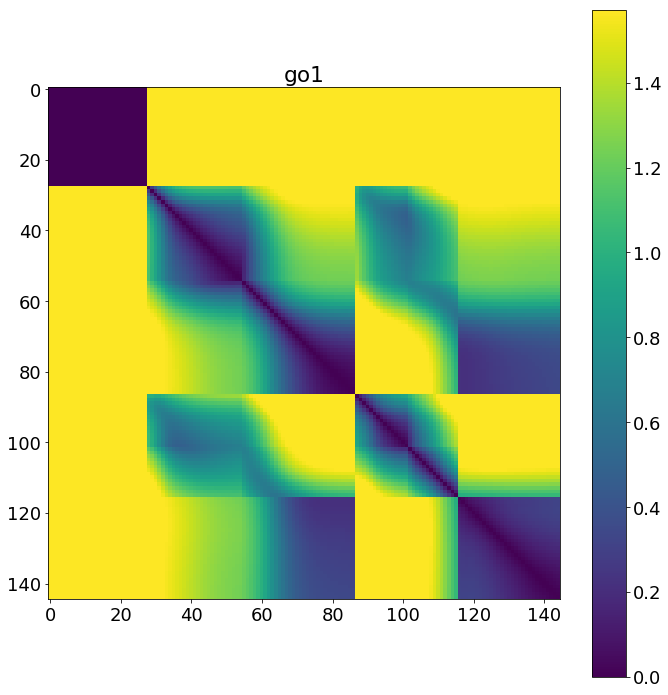

In [87]:
Beta_timeseries_set = {}
epoch_set = ['stim1', 'stim2', 'go1']

T,S,N = np.shape(h_tf)

for e in trial.epochs.keys():
    T_inds = range(T)
    Beta_timeseries = generate_Beta_timeseries(h_tf,trial,T_inds,e)
    Beta_timeseries_set[e] = Beta_timeseries

from tools_lnd import angle_between
ab = {}

for e in epoch_set:
    T_inds = range(T)#T_inds = get_T_inds(trial,e)
    ab[e] = np.empty((len(T_inds),len(T_inds),2))
    for r1_ind in range(len(T_inds)):
        for r2_ind in range(len(T_inds)):

            ab[e][r1_ind,r2_ind,0] = angle_between(Beta_timeseries_set[e][:,0,r1_ind],Beta_timeseries_set[e][:,0,r2_ind])
            ab[e][r1_ind,r2_ind,1] = angle_between(Beta_timeseries_set[e][:,1,r1_ind],Beta_timeseries_set[e][:,1,r2_ind])

# fig = plt.figure(figsize=(10,4*len(epoch_set)),tight_layout=True,facecolor='white')
# plt.rcParams.update({'font.size': 18})
# for e_ind in range(len(epoch_set)):
#     e = epoch_set[e_ind]
#     plt.subplot(len(epoch_set),2,1+2*e_ind)
#     plt.imshow(np.mean(ab[e],axis = 2))
#     plt.colorbar()
#     plt.clim(0,np.pi/2)
#     plt.title(e)

#     e = epoch_set[e_ind]
#     plt.subplot(len(epoch_set),2,2+2*e_ind)
#     plt.imshow(ab[e][:,:,1])
#     plt.colorbar()
#     plt.clim(0,np.pi/2)
#     plt.title(e)

fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})
plt.imshow(np.mean(ab[e],axis = 2))
plt.colorbar()
plt.clim(0,np.pi/2)
plt.title(e)

(0, 145)

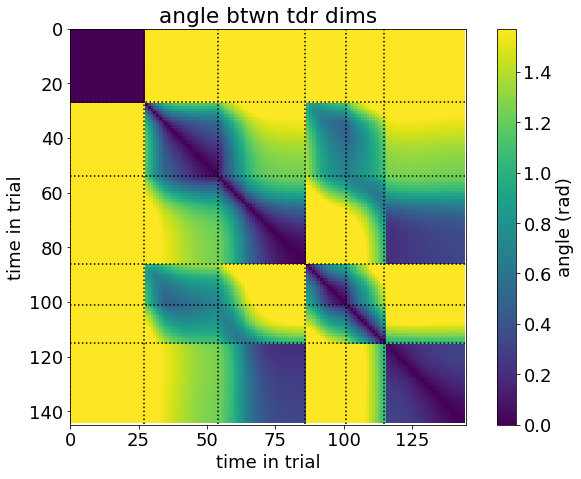

In [89]:
fig = plt.figure(figsize=(9,7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})
plt.imshow(np.mean(ab[e],axis = 2))

for e in trial.epochs.keys():
    T_inds = get_T_inds(trial,e)
    plt.plot([T_inds[0],T_inds[0]],[0,T],':k')
    plt.plot([0,T],[T_inds[0],T_inds[0]],':k')
cbar = plt.colorbar()
cbar.ax.set_ylabel('angle (rad)')
plt.clim(0,np.pi/2)
plt.ylabel('time in trial')
plt.xlabel('time in trial')
plt.title('angle btwn tdr dims')
plt.ylim((T,0))
plt.xlim((0,T))

In [90]:
def generate_Beta_timeseries_diff_align(h_tf,trial,T_inds):
    T,S,N = np.shape(h_tf)
    Beta_timeseries = np.empty((N,2,len(T_inds)))

    for t in T_inds:
            
        inds_use = np.min(trial.stim_strength,axis=1)>.5
        X = h_tf[t,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan

        stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
        stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
        y_loc = trial.y_loc[-1,:]
        
        if t<trial.epochs['stim2'][0]:
            angle_var = stim1_locs[inds_use]
        elif t<trial.epochs['go1'][0]:
            angle_var = stim2_locs[inds_use]
        else:
            angle_var = y_loc[inds_use]

        y1 = np.expand_dims(np.sin(angle_var),axis = 1)
        y2 = np.expand_dims(np.cos(angle_var),axis = 1)
        y = np.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_timeseries[:,:,t],_ = LA.qr(Beta)

    return Beta_timeseries

NameError: name 'e_ind' is not defined

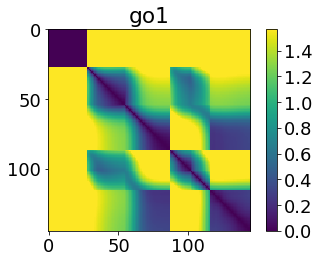

In [91]:
T,S,N = np.shape(h_tf)
T_inds = range(T)
Bt = generate_Beta_timeseries_diff_align(h_tf,trial,T_inds)

ab = np.empty((T,T,2))
for r1_ind in range(T):
    for r2_ind in range(T):

        ab[r1_ind,r2_ind,0] = angle_between(Bt[:,0,r1_ind],Bt[:,0,r2_ind])
        ab[r1_ind,r2_ind,1] = angle_between(Bt[:,1,r1_ind],Bt[:,1,r2_ind])
        
fig = plt.figure(figsize=(10,4),tight_layout=True,facecolor='white')

plt.subplot(1,2,1)
plt.imshow(ab[:,:,0])
plt.colorbar()
plt.clim(0,np.pi/2)
plt.title(e)

e = epoch_set[e_ind]
plt.subplot(1,2,2)
plt.imshow(ab[:,:,1])
plt.colorbar()
plt.clim(0,np.pi/2)
plt.title(e)

In [15]:
epoch_set = ['fix1', 'stim1', 'delay1', 'stim2', 'delay2', 'go1', 'output'] 

In [170]:
T,S,N = np.shape(h_tf)
D_mat = np.zeros((N,2,len(epoch_set)))

for e_ind in range(len(epoch_set)):
    D = []
    if epoch_set[e_ind]== 'output' :
        D = w_out[:,1:]
    else:
        D = make_axes(model_dir_all,ckpt_n_dir,rule,epoch_set[e_ind])
    D_mat[:,0,e_ind] = D[:,0]
    D_mat[:,1,e_ind] = D[:,1]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

In [171]:
from tools_lnd import angle_between
ab = np.empty((len(epoch_set),len(epoch_set),2))

for r1_ind in range(len(epoch_set)):
    for r2_ind in range(len(epoch_set)):
        
        ab[r1_ind,r2_ind,0] = angle_between(D_mat[:,0,r1_ind],D_mat[:,0,r2_ind])
        ab[r1_ind,r2_ind,1] = angle_between(D_mat[:,1,r1_ind],D_mat[:,1,r2_ind])

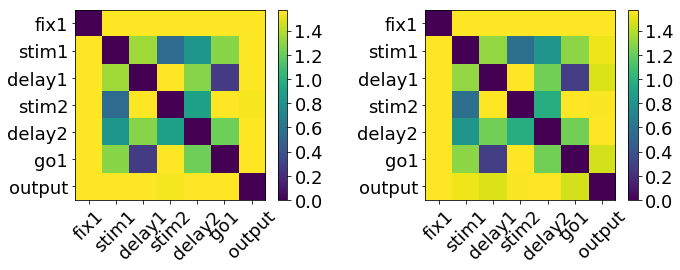

In [174]:
fig = plt.figure(figsize=(10,4),tight_layout=True,facecolor='white')
plt.subplot(1,2,1)
plt.imshow(ab[:,:,0])
plt.colorbar()
plt.clim(0,np.pi/2)
plt.yticks(range(len(epoch_set)),epoch_set)
plt.xticks(range(len(epoch_set)),epoch_set,rotation = 45)

plt.subplot(1,2,2)
plt.imshow(ab[:,:,1])
plt.colorbar()
plt.clim(0,np.pi/2)
plt.yticks(range(len(epoch_set)),epoch_set)
plt.xticks(range(len(epoch_set)),epoch_set,rotation = 45)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crys

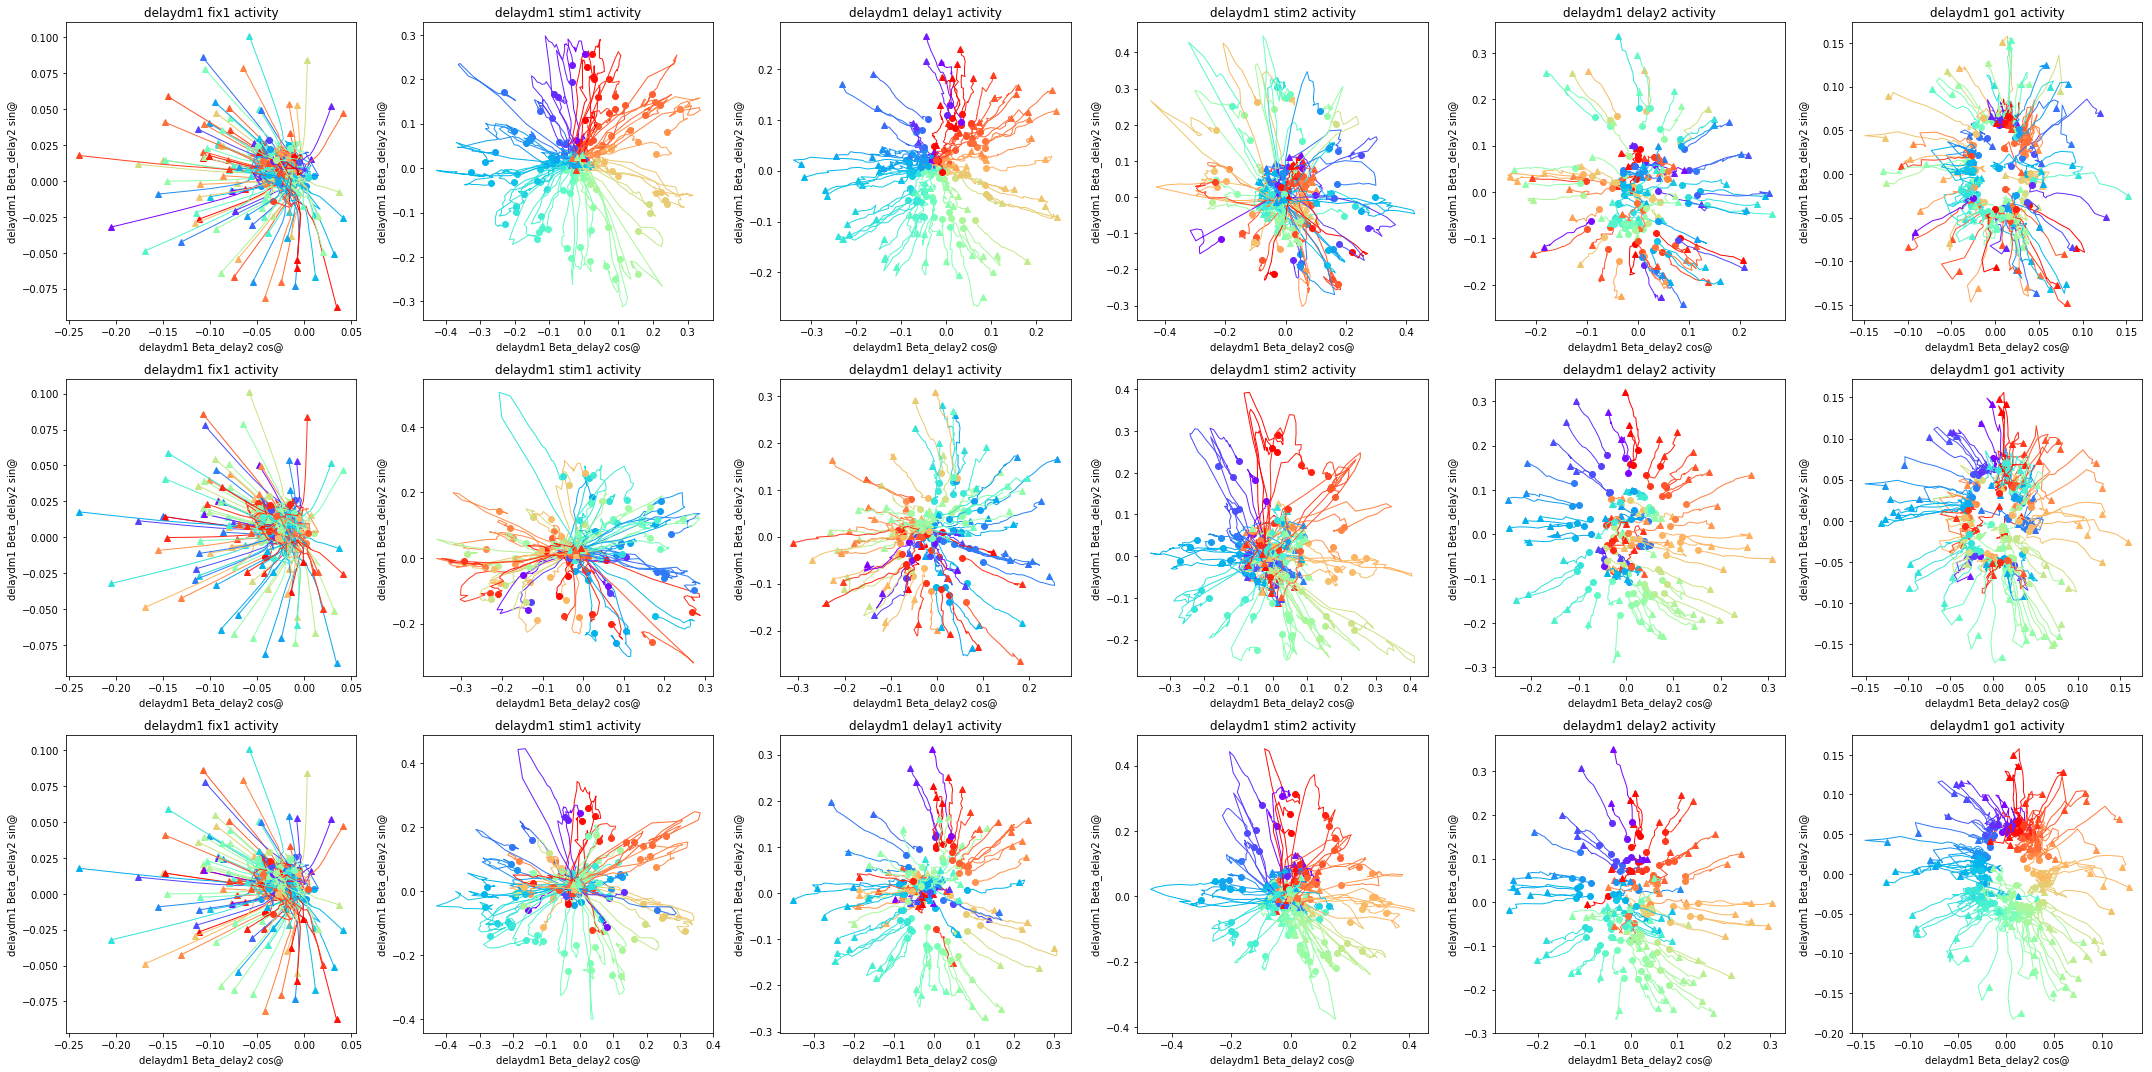

In [23]:
epoch_order = [4,0,2,1,3,5]
axes_epoch = 'delay2'

fig = plt.figure(figsize=(len(epoch_set)*5,15),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D_stim2 = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(3,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_stim2,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'stim1')
    plt.subplot(3,len(epoch_set),fp_epoch_ind+1+len(epoch_set))
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_stim2,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'stim2')
    plt.subplot(3,len(epoch_set),fp_epoch_ind+1+2*len(epoch_set))
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_stim2,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

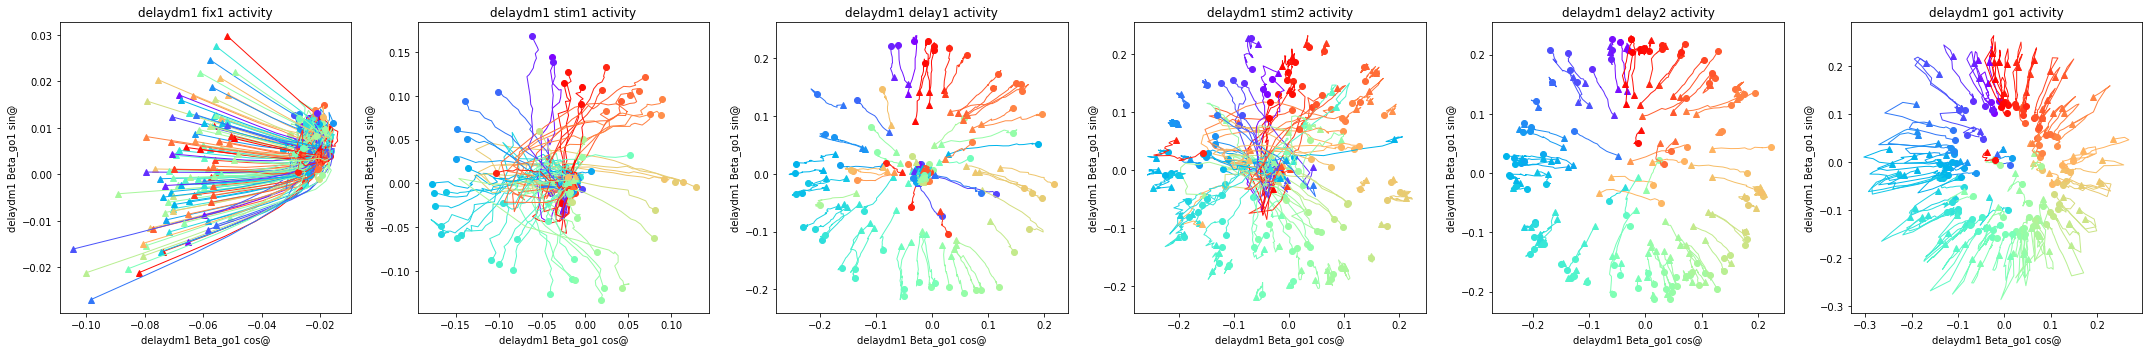

In [18]:
epoch_order = [4,0,2,1,3,5]
axes_epoch = 'go1'

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D_go = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D_go,fp_epoch,axes_epoch,do_plot_FP=0,color_label = axes_epoch)
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


IndexError: index 100 is out of bounds for axis 0 with size 100

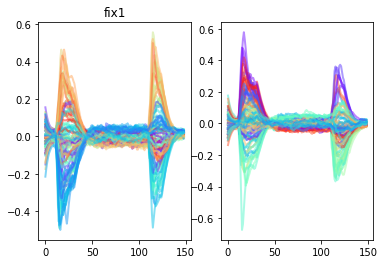

In [19]:
for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]

    D = make_axes(model_dir_all,ckpt_n_dir,rule,'stim2')

    cmap=plt.get_cmap('rainbow')

    model = Model(model_dir_all)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='random', batch_size = 100, noise_on=True, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
    stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
    y_loc = trial.y_loc[-1,:]

    if fp_epoch == 'stim1' or fp_epoch == 'delay1':
        c_inds = stim1_locs
    elif fp_epoch == 'stim2' or fp_epoch == 'delay1':
        c_inds = stim2_locs
    else:
        c_inds = y_loc

    for s in range(0,S):
        c = cmap(c_inds[s]/(2*np.pi))
        X_trial = np.dot(h_tf[:,s,:],D)
        plt.subplot(1,2,1)
        plt.plot(X_trial[:,0],'-',c = c, linewidth = 2,alpha = .5)
        plt.title(fp_epoch)
        plt.subplot(1,2,2)
        plt.plot(X_trial[:,1],'-',c = c, linewidth = 2,alpha = .5)
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/d

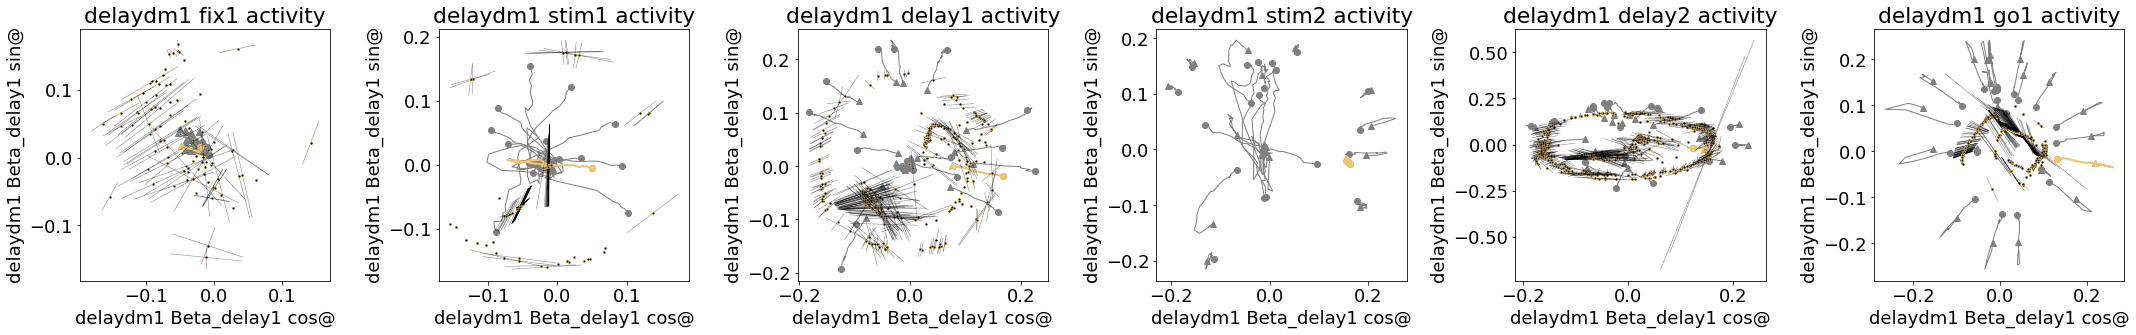

In [60]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0
axes_epoch = 'delay1'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .000001,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

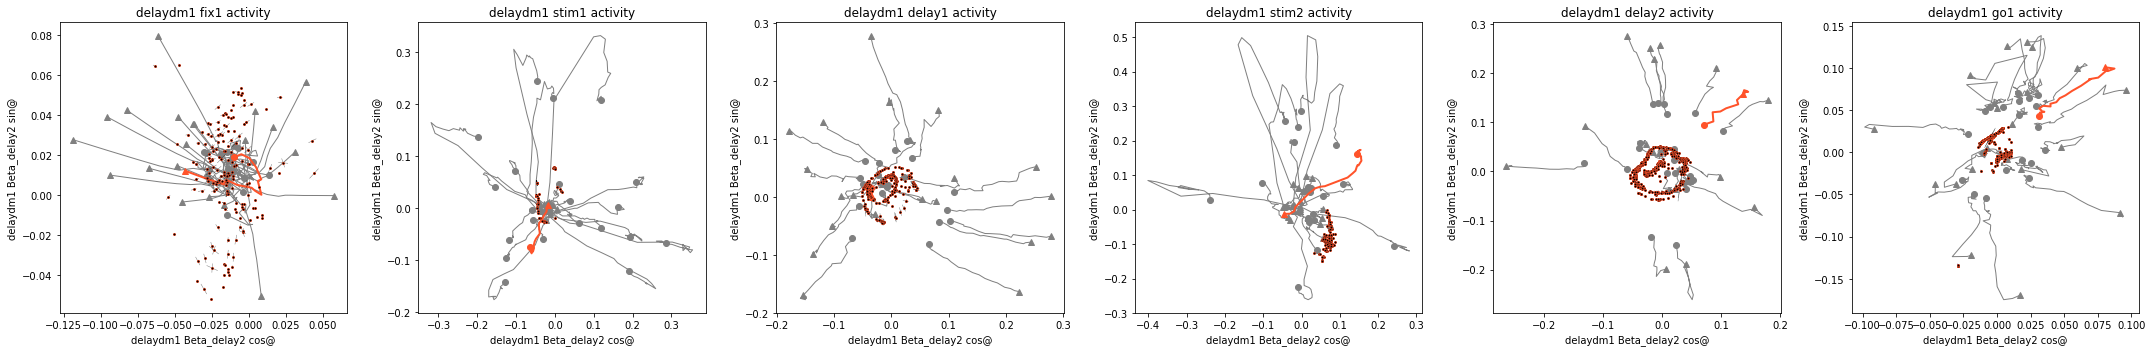

In [24]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 40
axes_epoch = 'delay2'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .00001,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

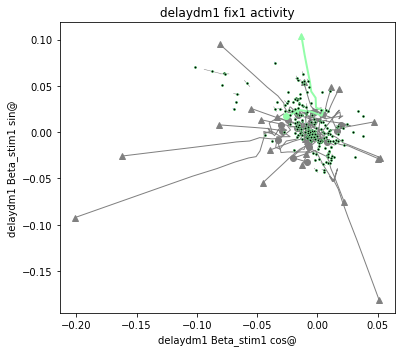

In [25]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 80
axes_epoch = 'stim1'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .0001,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

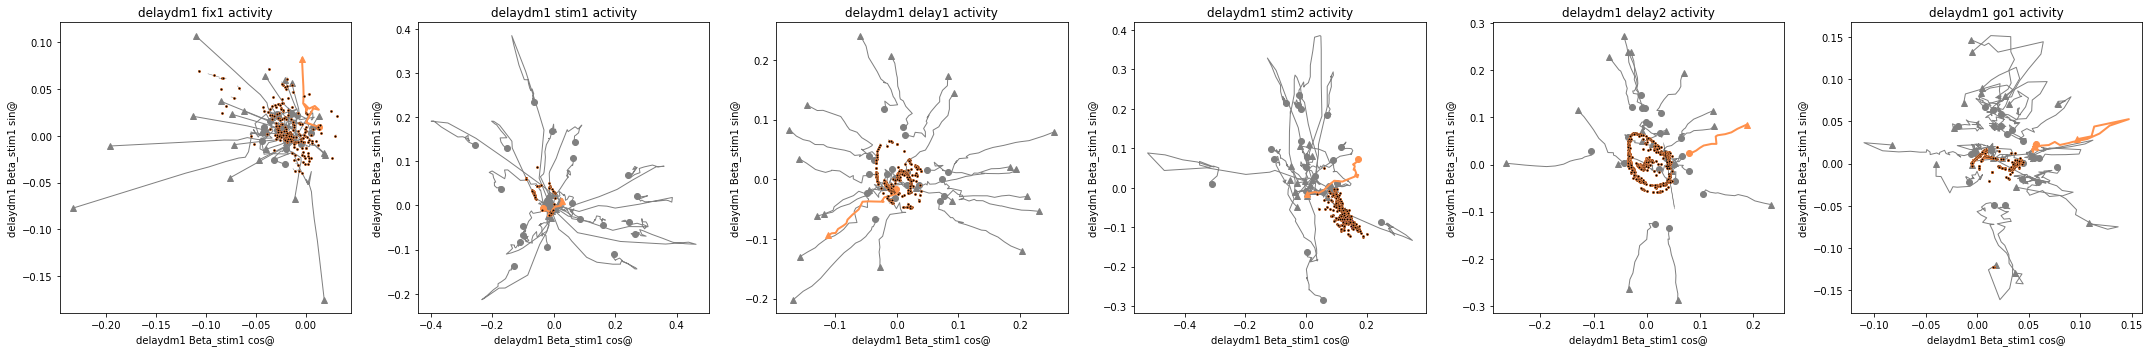

In [26]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 120
axes_epoch = 'stim1'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .0001,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

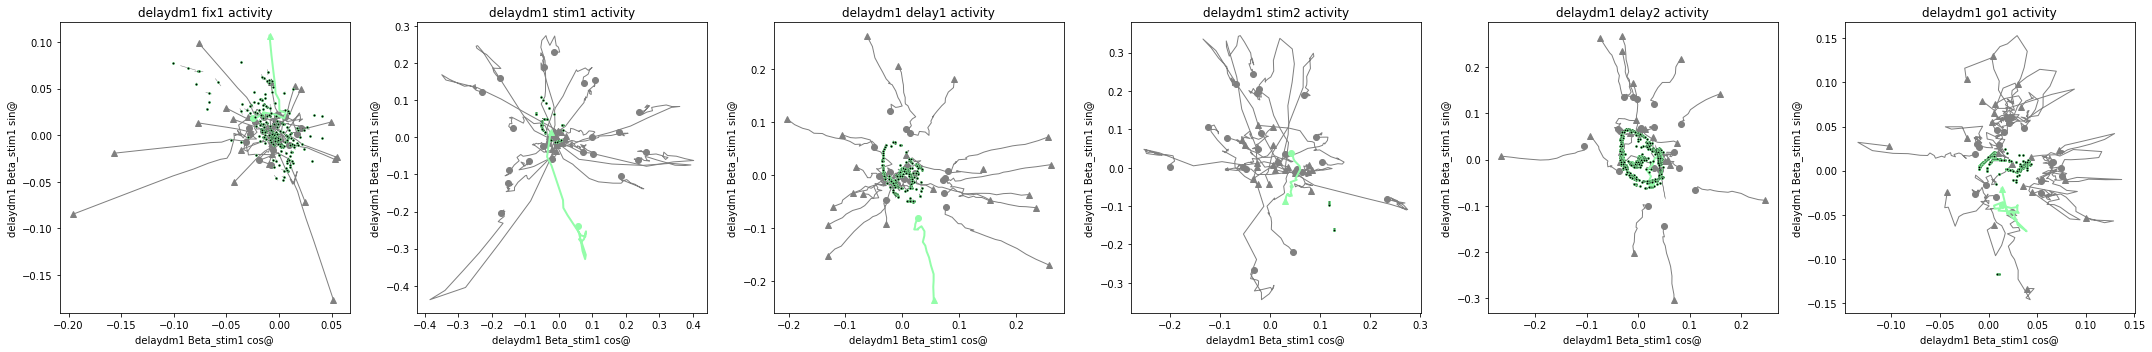

In [28]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 80
axes_epoch = 'stim1'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .0001,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [29]:
from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(model_dir_all,ckpt_n_dir)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

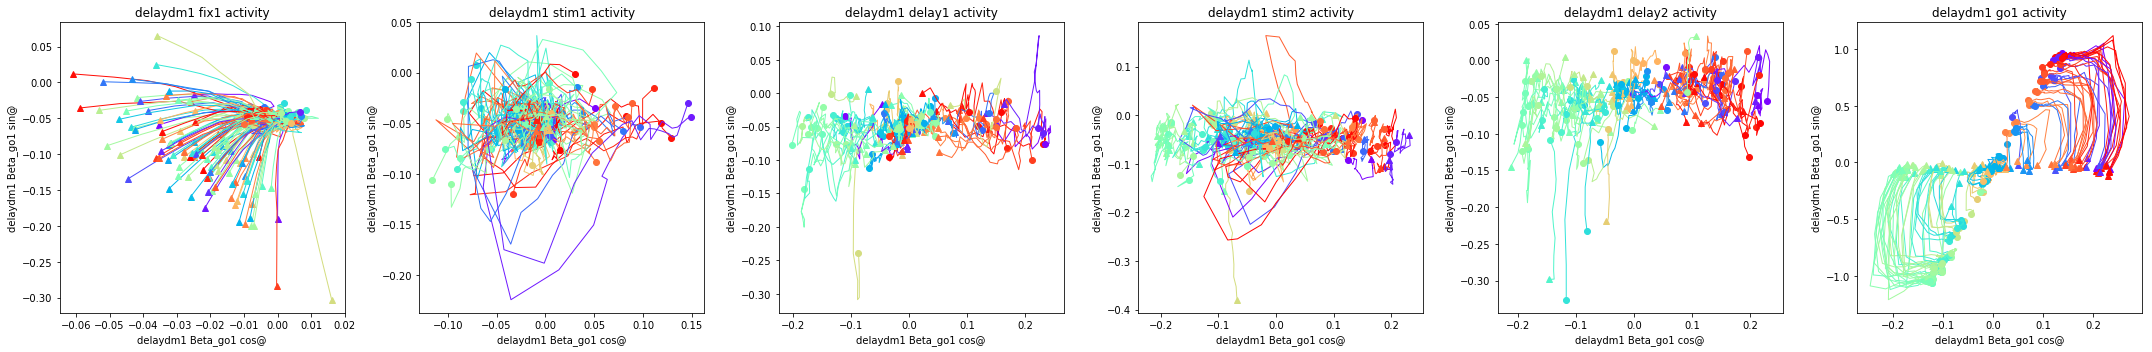

In [30]:
D_delay1 = make_axes(model_dir_all,ckpt_n_dir,'delaygo','delay1')
D = np.concatenate((D_delay1[:,1:2],w_out[:,2:3]),axis = 1)

axes_epoch = 'go1'

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=0,color_label = 'yloc')
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/delaydm1/fix1_0.npz
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/

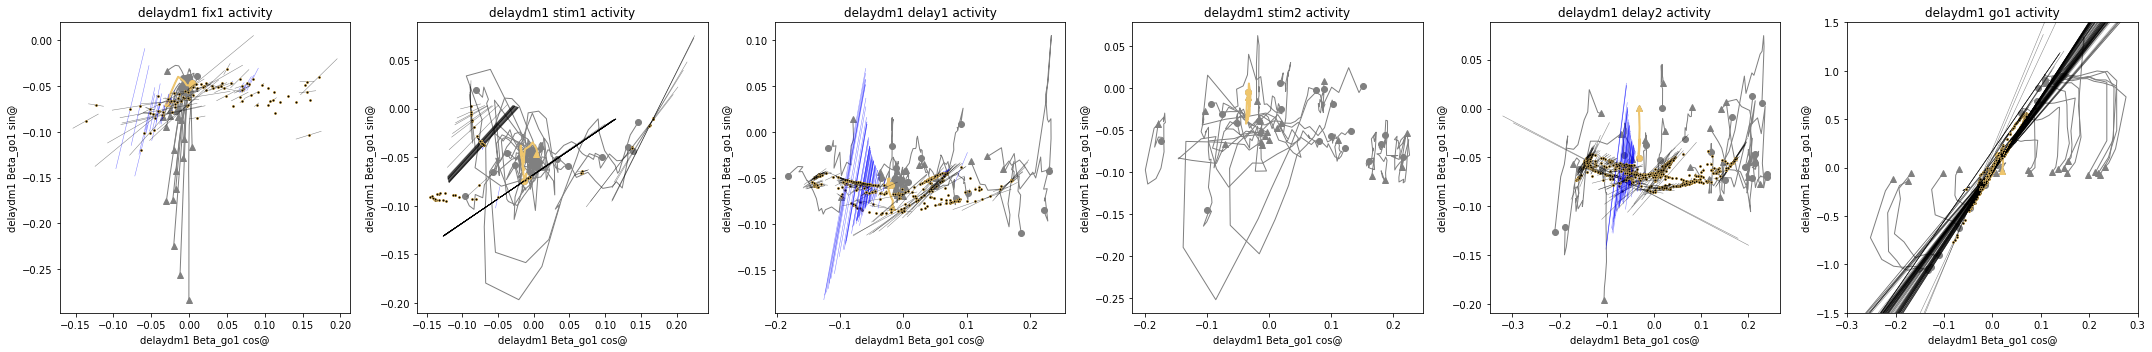

In [31]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = 0,color_label = 'yloc')
    
plt.ylim((-1.5,1.5))    
plt.xlim((-.3,.3)) 

figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/d

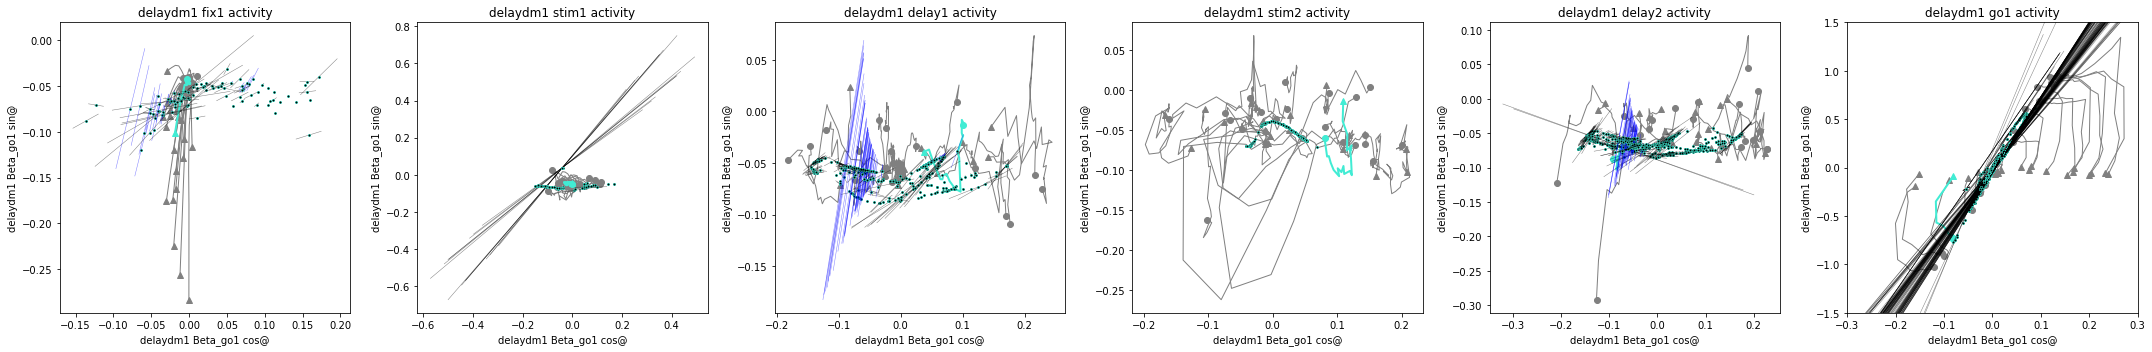

In [32]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 160

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,color_label = 'yloc')
    
plt.ylim((-1.5,1.5))    
plt.xlim((-.3,.3)) 

figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/d

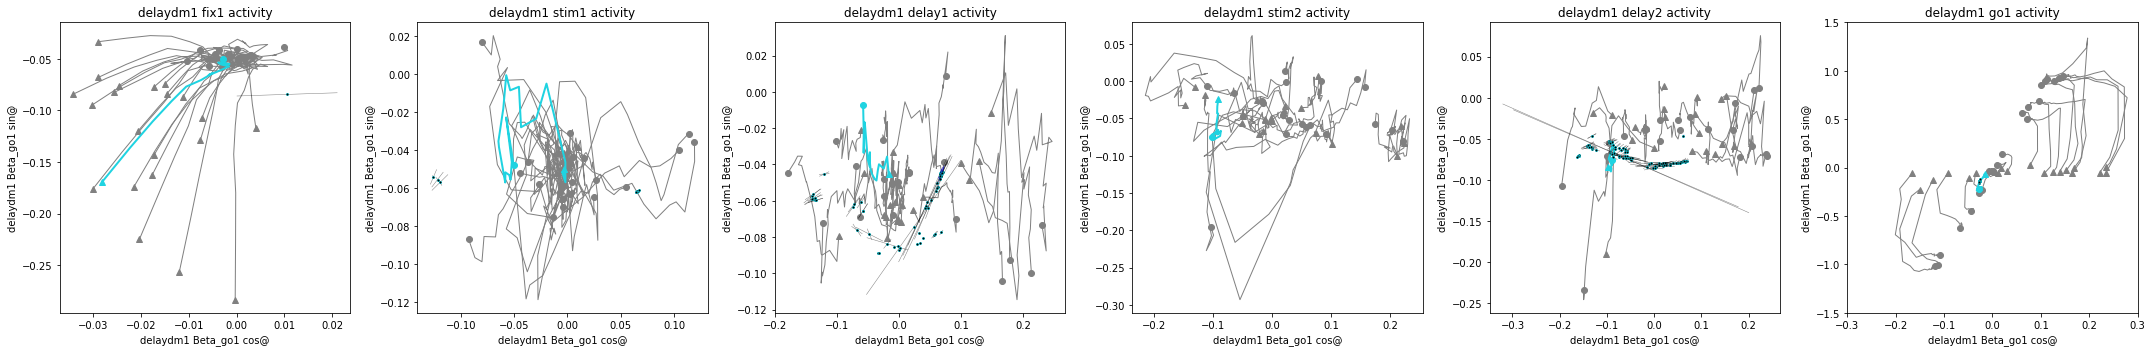

In [33]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 200

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,qlim = .000000001,t_num = t_num,color_label = 'yloc')
    
plt.ylim((-1.5,1.5))    
plt.xlim((-.3,.3)) 

figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1077000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/d

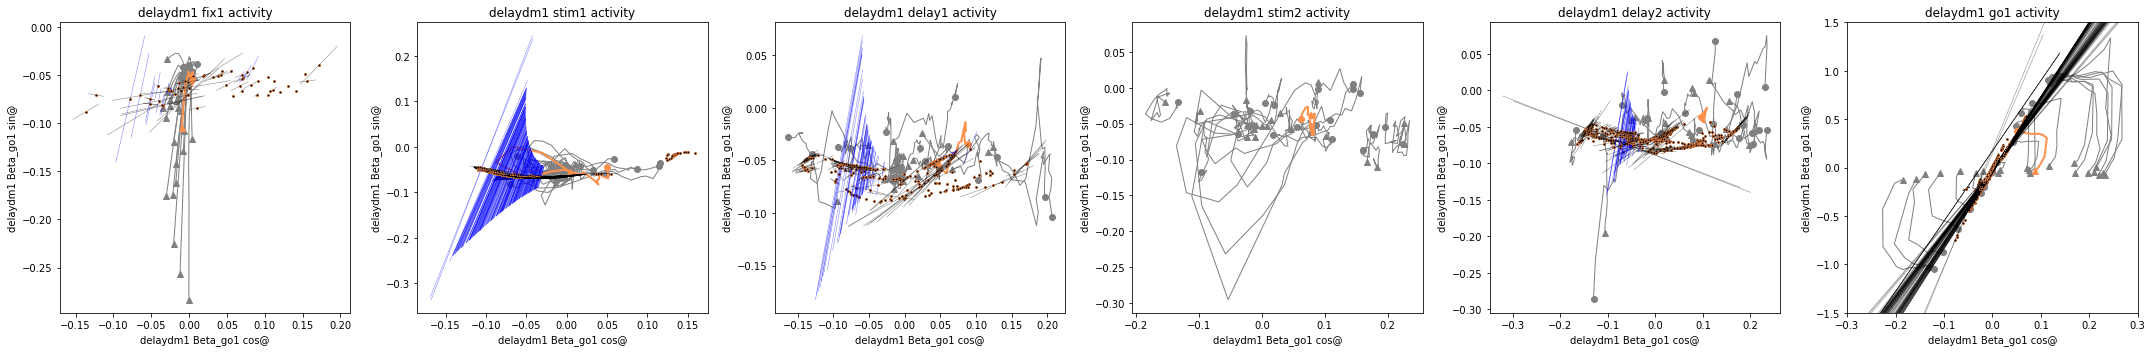

In [34]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 360

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,tasks,trial_set,rule,D,fp_epoch,axes_epoch,do_plot_FP=1,qlim = .0000001,t_num = t_num,color_label = 'yloc')
    
plt.ylim((-1.5,1.5))    
plt.xlim((-.3,.3)) 

figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()